<a href="https://colab.research.google.com/github/joel-winterton/Contagion/blob/main/Full%20simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib import colormaps
import geopandas as gpd
from matplotlib.ticker import FuncFormatter

In [2]:
data_path = "C:/Users/Joel/Downloads/BBCPandemic-20241015T141853Z-001/BBCPandemic"
processed_data_path = f"{data_path}/Processed"

## Within patch transition function

In [3]:
def make_transition_rate_fn(infectious_profile, reproductive_number, contact_matrix, group_sizes):
  """
  Precalculates parameters and returns function to calculate transition rates.
  """
  # Calculate A from contact matrix
  # multiply jth column by jth population and divide ith row by ith population using diagonal matrices
  A_hat = np.matmul(np.diag(1/group_sizes),np.matmul(contact_matrix , np.diag(group_sizes)))
  # Divide through by maximum eigenvalue
  rho = np.linalg.eigvals(A_hat).max()
  A = A_hat/rho
  tau_max = len(infectious_profile) - 1
  number_of_groups = len(group_sizes)
  infectious_profile_matrix = np.broadcast_to(infectious_profile[1:]/infectious_profile.sum(), (number_of_groups, len(infectious_profile)-1))

  def transition_rate_fn(t, state):
    """
    Calculates the transition rate for each group at time t in days given the state before t.
    Returns array where ith element is ith force of infection.
    """
    index = t + 5
    S,I = state
    infections = np.array(I[:,index-tau_max:index])
    transition_values = infectious_profile_matrix*np.matmul(A, infections)
    return reproductive_number*transition_values.sum(axis=1)

  return transition_rate_fn

# Between patch accounting

In [4]:
class Infections:
  def __init__(self,
               t_max,
               patch_ages,
               age_contact_matrix,
               distance_matrix,
               long_range_indicator,
               long_range_coeff,
               rural_urban,
               rural_proportions,
               urban_proportions,
               beta_profile,
               R_nought,
               branching_constant,
               mu):
    """
    t_max: Maximum number of days to run simulation for.
    patch_ages: Number of people in each age group for each patch, ndarray(patch, age_group).
    age_contact_matrix: Average contact matrix between age groups (called B for BBC in Contagion paper), ndarray(age_group, age_group).
    distance_matrix: Matrix containing distance (nearest km) between each patch, ndarray(patch, patch).
    long_range_indicator: Matrix with 1 if locations are wired in long range network, 0 else. ndarray(patch, patch).
    long_range_coeff: Coefficient for long range force of infection, float.
    rural_urban: Rural/urban classification for each patch, ndarray(patch).
    rural_proportions: Array containing proportion of time someone in rural patch spends d km from home, nparray(distance).
    urban_proportions: Same as rural_proprotions but for urban patches.
    beta_profile: Beta value for each day of infection, starting at 0, ndarray(length_of_infection). Will be normalised to sum to 1.
    R_nought: Basic reproductive number, float.
    branching_constant: Constant to determine epsilon from branching_constant = epsilon*(1-1/R_0)
    epsilon: Normalising constant for force of infection, float.
    mu: Power constant for population size dependance.
    """
    self.patch_ages = patch_ages
    self.beta_profile = beta_profile/beta_profile.sum()
    self.R_nought = R_nought
    self.t_max = t_max
    self.age_contact_matrix = age_contact_matrix
    self.long_range_indicator = long_range_indicator
    self.urban_proportions = urban_proportions
    self.rural_proportions = rural_proportions
    self.rural_urban= rural_urban
    self.distance_matrix = distance_matrix
    self.long_range_coeff = long_range_coeff
    self.mu = mu
    # Derived properties
    self.number_of_patches = patch_ages.shape[0]
    self.number_of_age_groups = patch_ages.shape[1]
    self.incidence = np.zeros(shape=(self.number_of_patches, self.t_max+6, self.number_of_age_groups))
    self.susceptibles = np.zeros(shape=(self.number_of_patches, self.t_max+6, self.number_of_age_groups))
    self.onset_times = np.full(shape=(self.number_of_patches), fill_value=self.t_max+2, dtype=int)
    self.group_sizes = self.patch_ages.sum(axis=1)
    self.epsilon = branching_constant*(1-1/self.R_nought)
  def simulate_patch(self, j:int, tau:int)->None:
    """
    Run deterministic model for patch j,
    and propogate simulation into susceptibles and incidence object,
    starting at index tau.
    """
    number_of_days = self.t_max - tau
    self.onset_times[j] = tau
    # first five entries are before t=0
    I = np.array([[0.002, 0.002, 0.002, 0.002, 0.002, 0.00]+[-1.]*number_of_days]*self.number_of_age_groups)
    S = np.array([[0., 0., 0., 0., 0., 0.99]+[-1.]*number_of_days]*self.number_of_age_groups)

    trans_fn = make_transition_rate_fn(self.beta_profile, self.R_nought, self.age_contact_matrix, self.patch_ages[j])
    for t in range(number_of_days):
      index = t+5
      forces_of_infection = trans_fn(t, (S,I))
      probability_of_infection = 1 - np.exp(-forces_of_infection)
      S[:,index+1] = S[:,index]*(1-probability_of_infection)
      I[:,index+1] = S[:,index]*probability_of_infection
    # Transpose
    self.incidence[j,tau:,:] = I.T
    self.susceptibles[j,tau:,:] = S.T

  def get_active_patches(self, t):
    """
    Returns indices of patches that have been infected by time t.
    """
    return np.argwhere(self.onset_times<=t).ravel()

  def get_inactive_patches(self, t):
    """
    Returns indices of patches have not been infected up to time t.
    """
    return np.argwhere(self.onset_times>t).ravel()

  def patch_effective_prevalence(self, j:int,t:int)->float:
    """
    Returns phi_j(t), the relative force of infection patch k exerts at t.
    """
    tau_indices = np.arange(1, len(self.beta_profile))
    incidence_slices = self.incidence[j, t - tau_indices[:, np.newaxis], :]
    weighted_incidence = (incidence_slices * self.patch_ages[j, :]).sum(axis=-1)
    return np.dot(self.beta_profile[1:], weighted_incidence)/(self.patch_ages[j,:].sum())

  def force_of_infection(self, j:int, t:int)->float:
    """
    Returns lambda_j(t), the force of infection on patch j at t.
    """
    patch_population_size = self.patch_ages[j,:].sum()
    active_patches = self.get_active_patches(t)
    patch_times = t - self.onset_times[active_patches]

    vectorised_patch_prevalence = np.vectorize(lambda patch,time: self.patch_effective_prevalence(patch, time))
    vectorised_proportions = np.vectorize(lambda l: self.distance_proportion(j, l))

    patch_forces = vectorised_patch_prevalence(active_patches, patch_times)
    patch_proportions = vectorised_proportions(active_patches)
    long_range_force = self.long_range_coeff*self.long_range_indicator[j, active_patches]
    force_of_infection = self.epsilon*(patch_population_size**self.mu)* (patch_forces*(patch_proportions+long_range_force)).sum()
    return force_of_infection

  def distance_proportion(self, j:int, l: int)->float:
    """
    Returns F_ru(j)(d_{jl}), the proportion of visits from rural/urban (depending on ru(j)) that are d_jl km from the origin.
    """
    d = self.distance_matrix[j,l]
    if self.rural_urban[j]:
      return self.rural_proportions[d]
    else:
      return self.urban_proportions[d]

  def simulate_between_patch(self, seed_location, seed_time):
    """
    This brings everything together by simulating between patch.
    """
    # Seed
    self.simulate_patch(j=seed_location, tau=seed_time)
    # Move forward in time
    for t in range(self.t_max - seed_time):
      # Calculate infection forces
      patches = self.get_inactive_patches(t)
      vectorised_force_of_infection = np.vectorize(lambda j: self.force_of_infection(j, t), otypes=[float])
      forces_of_infection = vectorised_force_of_infection(patches)
      # Probability to seed in that location
      probability_of_infection = 1 - np.exp(-forces_of_infection)
      # Seed patches with probability from above
      unif_samples = np.random.default_rng().uniform(size=len(patches))
      seed_patches = unif_samples<=probability_of_infection
      indexes_to_seed = patches[seed_patches]
      for index in indexes_to_seed:
        self.simulate_patch(j=index, tau=t)


# Bring in the data


In [5]:
# Maximum time
t_max = 250

# Patch population by ages (and patch id to LDA code)
patch_ages = pd.read_csv(processed_data_path+"/lad_population_by_age.csv", header=None, skiprows=1)
patch_id_to_lad = patch_ages[0].values
patch_ages.drop(columns=0, inplace=True)
patch_ages = patch_ages.values

# Age contact matrix
age_contact_matrix = pd.read_csv(processed_data_path+"/contact_polymod.csv", header=None, skiprows=1)
age_contact_matrix.drop(columns=0, inplace=True)
age_contact_matrix = age_contact_matrix.values

# Patch distances
distance_matrix = pd.read_csv(processed_data_path+"/centroid_distances.csv", header=None, skiprows=1)
distance_matrix.drop(columns=0, inplace=True)
distance_matrix = distance_matrix.values

# Rural/Urban classification
rural_urban = pd.read_csv(processed_data_path+"/rural_data.csv")
rural_urban = rural_urban['rural'].values

# Flux proportions
urban_proportions = pd.read_csv(processed_data_path+"/urban_proportions.csv")
urban_proportions.set_index('Unnamed: 0', inplace=True)
urban_proportions = np.array([urban_proportions.loc[i,'count'] if i in urban_proportions.index else 0 for i in range(distance_matrix.max()+1)])

rural_proportions = pd.read_csv(processed_data_path+"/rural_proportions.csv")
rural_proportions.set_index('Unnamed: 0', inplace=True)
rural_proportions = np.array([rural_proportions.loc[i,'count'] if i in rural_proportions.index else 0 for i in range(distance_matrix.max()+1)])

# Long range network
long_range_indicator = pd.read_csv(processed_data_path+"/long_jump_indicator.csv")
long_range_indicator.set_index('Unnamed: 0', inplace=True)
long_range_indicator = long_range_indicator.values

long_range_coeff = 0.5*urban_proportions[100]

# Infectivity parameters
beta_profile = np.array([0., 0., 1.6, 0.8, 0.2, 0.2])
R_nought = 1.8
dampened_R_nought = 1.41
branching_constant = 22.5
mu = 0.32

# Haslemere (roughly)+
seed_patch = 97

# Whack it all together

In [6]:
def go(r_nought):
  infections = Infections(t_max=t_max,
                        patch_ages=patch_ages,
                        age_contact_matrix=age_contact_matrix,
                        distance_matrix = distance_matrix,
                        long_range_indicator=long_range_indicator,
                        long_range_coeff=long_range_coeff,
                        rural_urban = rural_urban, 
                        rural_proportions=rural_proportions,
                        urban_proportions=urban_proportions,
                        beta_profile=beta_profile,
                        R_nought=r_nought,
                        branching_constant=branching_constant,
                        mu=mu)
  infections.simulate_between_patch(seed_location=seed_patch, seed_time=0)
  return infections
infections = go(R_nought)
infections_controlled = go(dampened_R_nought)

C:\Users\Joel\AppData\Local\Temp\ipykernel_7740\473303750.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  S[:,index+1] = S[:,index]*(1-probability_of_infection)
C:\Users\Joel\AppData\Local\Temp\ipykernel_7740\473303750.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  I[:,index+1] = S[:,index]*probability_of_infection


# Analyse data

## Case count

(array([ 5., 12., 56., 46., 38., 77., 32., 51.,  7.,  2.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

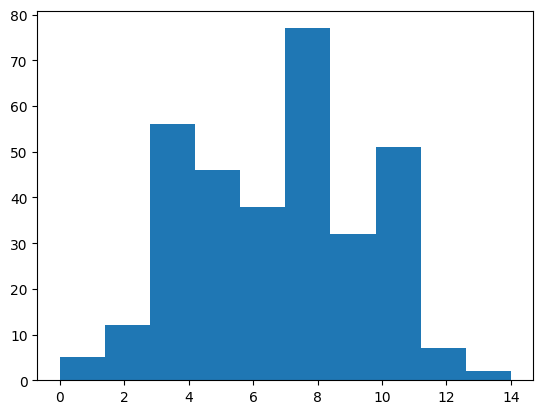

In [7]:
plt.hist(infections.onset_times//7)

## Cumulative cases

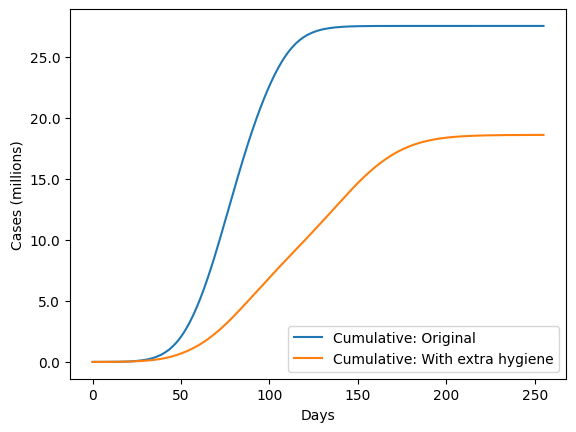

In [8]:
population_size_multiplier = np.repeat(infections.patch_ages[:, np.newaxis,], infections.incidence.shape[1], axis=1)
absolute_incidence = infections.incidence * population_size_multiplier
absolute_incidence_controlled = infections_controlled.incidence * population_size_multiplier
fig, ax = plt.subplots()
plt.plot(np.arange(256), np.cumsum(absolute_incidence.sum(axis=0).sum(axis=1)), label='Cumulative: Original')
plt.plot(np.arange(256), np.cumsum(absolute_incidence_controlled.sum(axis=0).sum(axis=1)), label='Cumulative: With extra hygiene')

ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: f'{x / 1000000}'))
plt.ylabel('Cases (millions)')
plt.xlabel('Days')
plt.legend()
plt.show()

# Patch cumulative
infections.incidence.shape

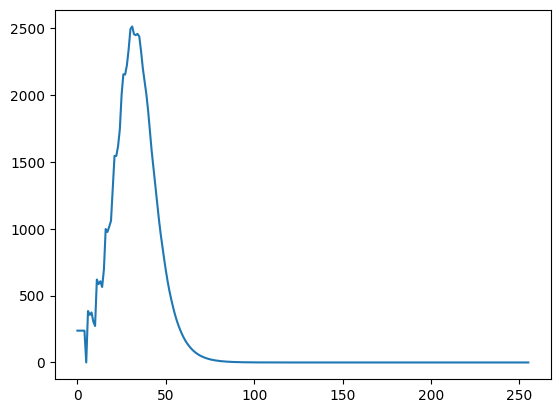

In [9]:
plt.plot(np.arange(256),(infections.incidence[97,:,:]*infections.patch_ages[97]).sum(axis=1))
plt.show() 

## Incidence

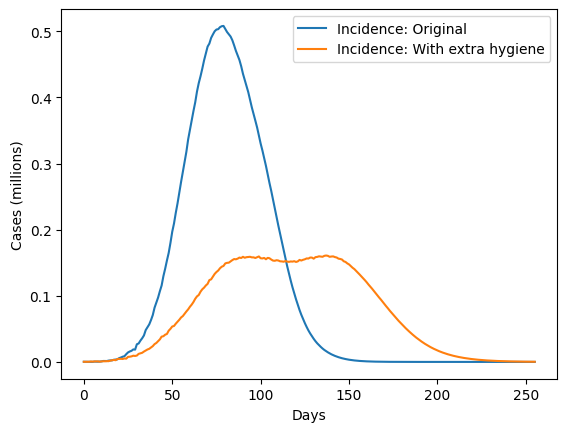

In [10]:
fig, ax = plt.subplots()
plt.plot(np.arange(256), absolute_incidence.sum(axis=0).sum(axis=1), label='Incidence: Original')
plt.plot(np.arange(256),absolute_incidence_controlled.sum(axis=0).sum(axis=1), label='Incidence: With extra hygiene')

ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: f'{x / 1000000}'))
plt.ylabel('Cases (millions)')
plt.xlabel('Days')
plt.legend()
plt.show()

## Spatial onset

In [11]:
lads = gpd.read_file(f"{data_path}/ONS LAD Boundaries December 2017/LAD_DEC_2017_GB_BGC_V5.shp")
# Filter to LADs we include in the simulation
lads = lads.loc[lads['LAD17CD'].isin(patch_id_to_lad)]
if lads.crs != "EPSG:27700":
    lads = lads.to_crs(epsg=27700)
circle_radii = pd.read_csv(f"{processed_data_path}/lad_radii.csv")
lads['radius'] = np.concatenate((circle_radii['radius'],np.zeros(lads.shape[0]-circle_radii.shape[0])))

lads['centroid'] = lads.centroid

lads['circle'] = lads.centroid.buffer(lads['radius'])


In [19]:
def spatial_plot(onset_times, map, title, colormap='plasma'):
    week_to_truncate_at = 18
    
    fig, ax = plt.subplots(figsize=(20, 20))
    map['onset'] = onset_times
    
    map['onset'] = map['onset'].apply(lambda x: x/7 + 1 if x<=week_to_truncate_at*7 else week_to_truncate_at)
    
    norm = mcolors.Normalize(vmin=lads['onset'].min(), vmax=week_to_truncate_at)
    cmap = colormaps[colormap]
    map['color'] = map['onset'].apply(lambda x: cmap(norm(x)))
    map.at[seed_patch, 'color'] = (0., 0.0, 0.0, 1.)
    map.boundary.plot(ax=ax, color="black", linewidth=0.1)
    map.plot(ax=ax, color=lads['color'], alpha=0.7)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for the colorbar
    cbar = fig.colorbar(sm, ax=ax)
    ax.set_axis_off()
    cbar.set_label('Onset week')
    
    plt.title(title)
    plt.show()

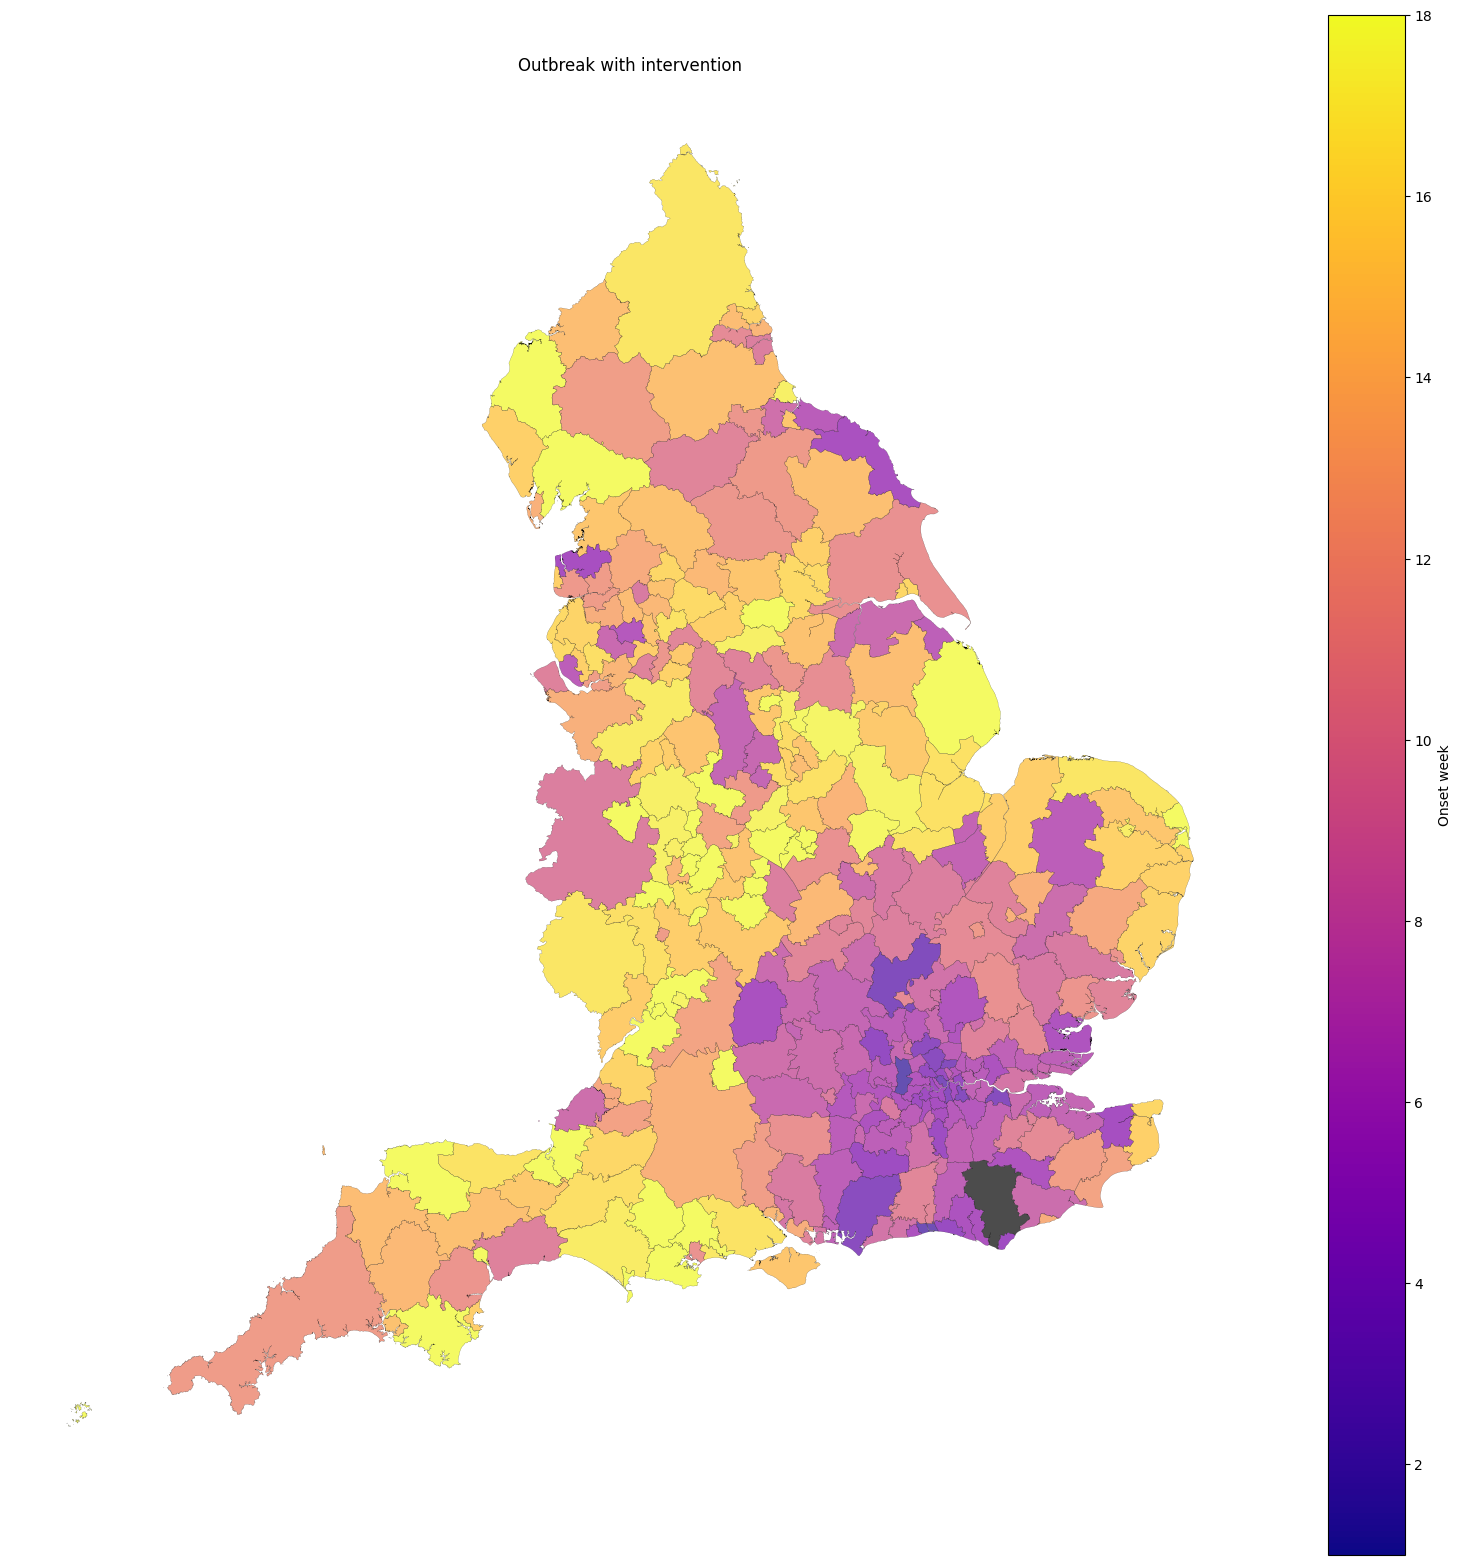

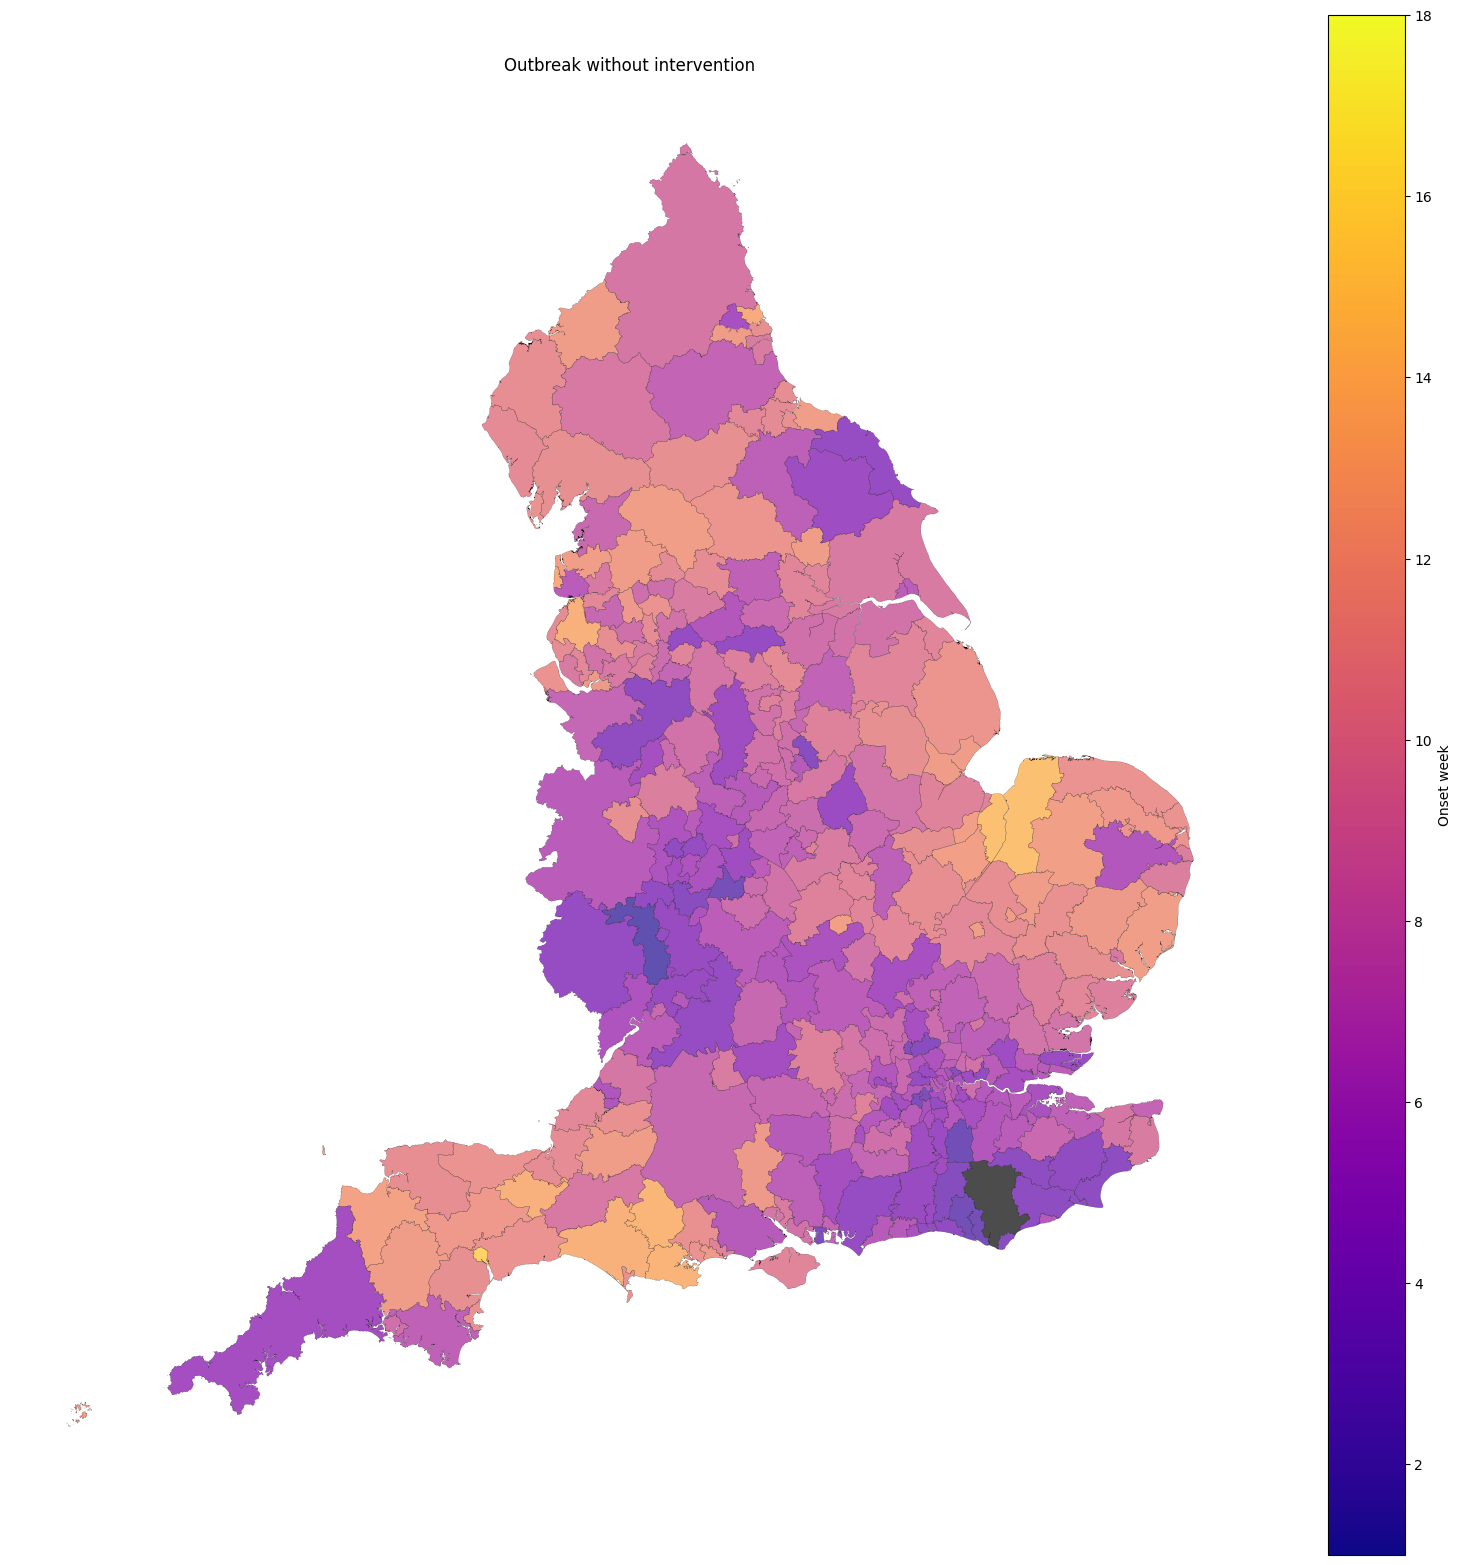

In [20]:
spatial_plot(infections_controlled.onset_times, lads,'Outbreak with intervention')
spatial_plot(infections.onset_times, lads,'Outbreak without intervention')


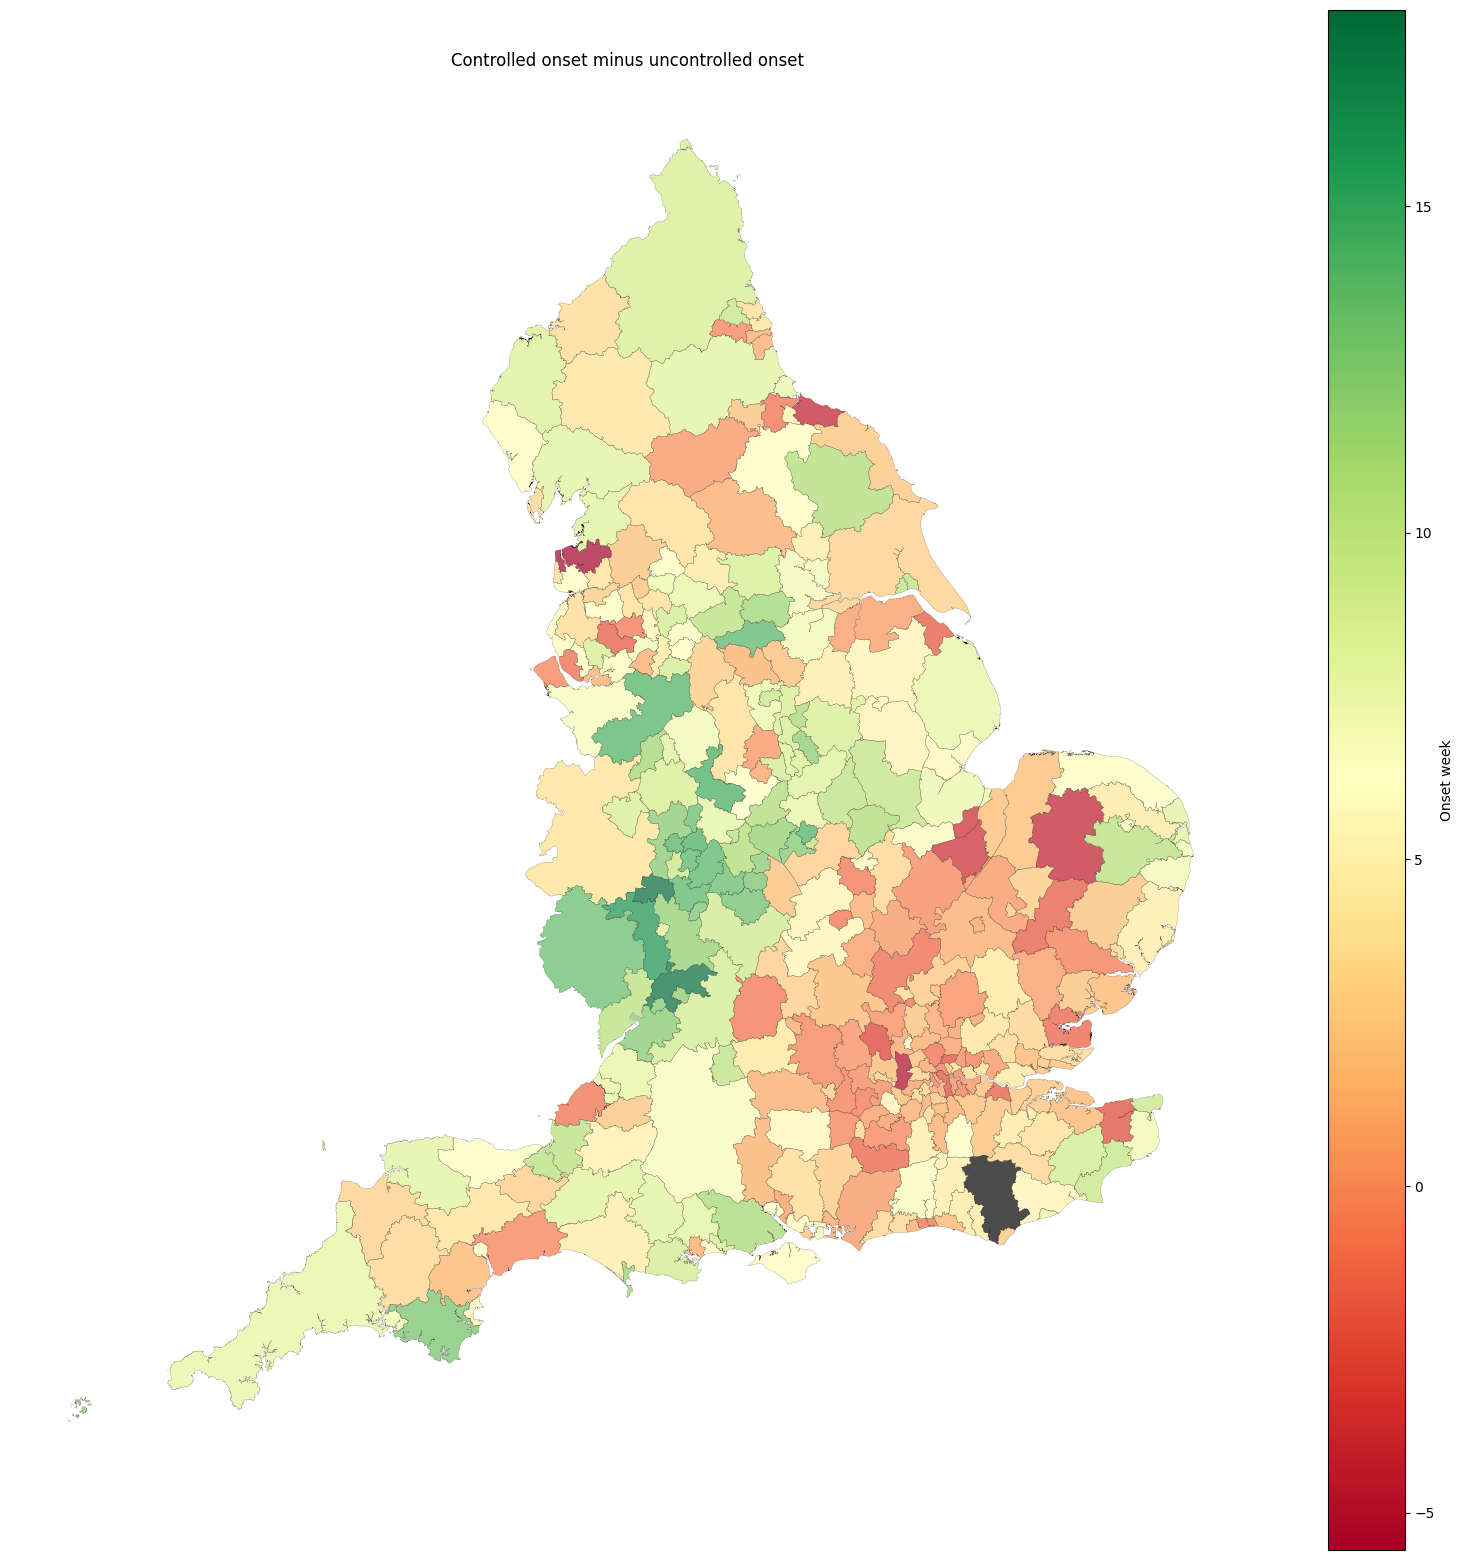

In [23]:
spatial_plot(infections_controlled.onset_times - infections.onset_times, lads,'Controlled onset minus uncontrolled onset ', colormap='RdYlGn')
